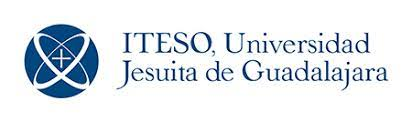
<h1><center>ITESO PhD in Engineering Sciences</h1></center>

<center>DOCTORAL PROGRAM IN ENGINEERING SCIENCES AT ITESO</center>
<center>RECTIFICATION OF THERMAL IMAGE REPRESENTATION USING NEURAL NETWORKS BY USING CHEAP THERMAL FLIR© CAMERA.</center>
<center>Marco Ramirez-Martagon, Ivan Villalon-Turrubiates, and Oscar Rojas-Rejon</center>
        
<center>July 1, 2021</center>
<center>Tlaquepaque, México 45604</center>
<center>Doctoral Program in Engineering Sciences</center>
<center>ITESO (Instituto Tecnológico y de Estudios Superiores de Occidente)</center>

<h3>Introduction</h3>

    Remote Sensing such as Thermal Images is an othet technique to analise and determinate the thermal behavior on some particular system. Determinate a single point temperature involve some basic kenoledge of Planck Lay. Hardware thermal detectors are affected by the object distance, and other environment variables. Attenuation by the atmosphere affect the infrared energy detected by the hardware. Neural networks help to predict the output value based on input values with some degree of accuracy, even help to copy functions/systems bahavior with some level of accuracy. 
    
<h3>Experiment</h3> 
     
    A 16x16x16x1 network was developed and trained to predict with +/- .89 K of accuracy.
    
   

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
#import collections
import subprocess
import time
import json
import csv
import os
import io
%matplotlib inline
# Avoid pritn Warnings 
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
tf.__version__

# Install Tools and Libraries

In [ ]:

! apt install exiftool
! apt install tesseract-ocr
! apt install libtesseract-dev
! apt install tesseract-ocr-cym
! apt-get install tesseract-ocr-LANG
! pip install pytesseract
! pip install google-cloud-vision
! pip install easyocr
print("============= DONE : Tools installed =======================")

In [ ]:
import pytesseract
import easyocr

In [ ]:
!git clone https://github.com/marcomartagon/ITESO-phd-IDI10.git

In [ ]:
def extractDigitstoFloat(Str):
    tmp=''.join(c for c in Str if (c.isdigit() or c=='.') )
    if ( len ( tmp.split('.') ) > 1 ) :
      digit = tmp.split('.')[0]+'.'+tmp.split('.')[1]
    else :
      digit = tmp
    return float(digit)

In [ ]:
# (C) Marco Ramirez-Martagon
# Author  : Marco Ramirez-Martagon
# Date    : Aug. 1 2021
# Version : 0.1
# ITESO PhD in Engineering Sciences
def getThermal(JPGFile,debug=False,H5=None):

   RAW_IMG          = None
   RAW_DATA         = None
   VISUAL_IMG       = None
   v0x0000          = np.vectorize(hex)
   ByteOrder        = None
   SpotRGB_image    = None
   SpotBW_image     = None
   Y_hat            = None
   RadiometricImage = None
    
   TagDic={     'ObjectDistance'              :0.0,
                'Emissivity'                  :0.0,
                'ReflectedApparentTemperature':0.0,
                'IRWindowTemperature'         :0.0,
                'IRWindowTransmission'        :0.0,
                'PlanckB'                     :0.0,
                'PlanckO'                     :0.0,
                'PlanckR1'                    :0.0, 
                'PlanckR2'                    :0.0,
                'AtmosphericTransAlpha1'      :0.0,
                'AtmosphericTransAlpha2'      :0.0,
                'AtmosphericTransBeta1'       :0.0,
                'AtmosphericTransBeta2'       :0.0,
                'AtmosphericTransX'           :0.0
          }

   SpotDic={    'RawX'    : None, 
                'RawY'    : None,
                'Raw'     : None,
                'K'       : None,
                'C'       : None} # Temp in Kelvin and Celcius

   ImgSizeDic={ 'ExifImageWidth'        : None,
                "RawThermalImageWidth"  : None,
                "ExifImageHeight"       : None,
                "RawThermalImageHeight" : None }

   RawStatDic={'Max'   : None,
               'Min'   : None,
               'Slope' : None}
   
   try :
        RadiometricImage=Image.open(JPGFile)
        process_catch = subprocess.check_output(['exiftool',  '-j', JPGFile])
        D             = json.loads(process_catch.decode())[0]

        if  ("EmbeddedImage" in D) or ("ThumbnailImage" in D) :
            if   ("EmbeddedImage" in D): 
                  process_catch = subprocess.check_output(['exiftool', "-EmbeddedImage", "-b", JPGFile])
            elif ("ThumbnailImage" in D):
                  process_catch = subprocess.check_output(['exiftool', "-ThumbnailImage", "-b", JPGFile])
            else :
                  print("ERROR : RGB Image not found")                
            process_bytes = io.BytesIO(process_catch)
            VISUAL_IMG       = Image.open(process_bytes)
            if debug:
                print("INFO : Visual Image processed")
                                                    
        if "RawThermalImage" in D:
            TagDic['ObjectDistance']              = extractDigitstoFloat(D['ObjectDistance'])
            TagDic['Emissivity']                  = D['Emissivity'] 
            TagDic['RelativeHumidity']            = extractDigitstoFloat(D['RelativeHumidity']) # Constant
            TagDic['ReflectedApparentTemperature']= extractDigitstoFloat(D['ReflectedApparentTemperature'])
            TagDic['AtmosphericTemperature']      = extractDigitstoFloat(D['AtmosphericTemperature'])
            TagDic['IRWindowTemperature']         = extractDigitstoFloat(D['IRWindowTemperature'])
            TagDic['IRWindowTransmission']        = D['IRWindowTransmission']
            TagDic['PlanckB']                     = D['PlanckB']
            TagDic['PlanckF']                     = D['PlanckF'] # Constant
            TagDic['PlanckO']                     = D['PlanckO']
            TagDic['PlanckR1']                    = D['PlanckR1'] 
            TagDic['PlanckR2']                    = D['PlanckR2']
            TagDic['AtmosphericTransAlpha1']      = D['AtmosphericTransAlpha1'] # Constant
            TagDic['AtmosphericTransAlpha2']      = D['AtmosphericTransAlpha2'] # Constant
            TagDic['AtmosphericTransBeta1']       = D['AtmosphericTransBeta1']  # Constant
            TagDic['AtmosphericTransBeta2']       = D['AtmosphericTransBeta2']  # Constant
            TagDic['AtmosphericTransX']           = D['AtmosphericTransX']      # Constant
            
            process_catch = subprocess.check_output(['exiftool', "-RawThermalImage", "-b", JPGFile])
            process_bytes = io.BytesIO(process_catch)
            RAW_IMG       = Image.open(process_bytes)
            RAW_DATA      = np.asarray(RAW_IMG)
            
            if debug :
                print("===== Raw Data Shape:{} Type:{} ==========".format(RAW_DATA.shape,RAW_DATA.dtype))
                print(v0x0000(RAW_DATA[50:55] ))
            
            ByteOrder   = D['ExifByteOrder']
    
            if ByteOrder.upper().find('LITTLE-ENDIAN') >= 0 :
                if debug:
                    print("INFO : Apply {} translation ".format(ByteOrder))
                RAW_DATA = np.vectorize(lambda x: (x >> 8) + ((x & 0x00ff) << 8))(RAW_DATA)                    
                
                if debug:
                    print("===== Raw Data Shape:{} Type:{} Transformed by {} ==========".format(RAW_DATA.shape,RAW_DATA.dtype,ByteOrder))
                    print(v0x0000(RAW_DATA[50:55] ))
                RAW_IMG=Image.fromarray(  (RAW_DATA * 255).astype(np.uint8)   )
            else:
                RAW_IMG=Image.fromarray(RAW_DATA)
            
            RawStatDic['Max']=np.max(RAW_DATA)
            RawStatDic['Min']=np.min(RAW_DATA)
            RawStatDic['Slope']=np.max(RAW_DATA)-np.min(RAW_DATA)
            
            if H5 is not None :
               try:
                        _, h5name = os.path.split(H5)
                        if debug:
                            print("INFO : Loading model {}".format(h5name))
                        model = tf.keras.models.load_model(H5)
                        NumberFeatures = model.layers[0].input.shape[1]
                        C1=RAW_DATA.flatten().T
                        Y=np.zeros( (C1.shape[0], NumberFeatures-1) )
                        if NumberFeatures == 10 :
                            Y[:, [0]] = TagDic['ObjectDistance']
                            Y[:, [1]] = TagDic['Emissivity']
                            Y[:, [2]] = TagDic['ReflectedApparentTemperature']
                            Y[:, [3]] = TagDic['IRWindowTemperature']
                            Y[:, [4]] = TagDic['IRWindowTransmission']
                            Y[:, [5]] = TagDic['PlanckB']
                            Y[:, [6]] = TagDic['PlanckO']
                            Y[:, [7]] = TagDic['PlanckR1']
                            Y[:, [8]] = TagDic['PlanckR2']
                            Y=np.insert(Y, 0, C1, axis=1)
                        elif NumberFeatures == 18:
                            Y[:, [0]] = TagDic['ObjectDistance']
                            Y[:, [1]] = TagDic['Emissivity']
                            Y[:, [2]] = TagDic['ReflectedApparentTemperature']
                            Y[:, [3]] = TagDic['AtmosphericTemperature']
                            Y[:, [4]] = TagDic['IRWindowTemperature']
                            Y[:, [5]] = TagDic['IRWindowTransmission']
                            Y[:, [6]] = TagDic['RelativeHumidity']
                            Y[:, [7]] = TagDic['PlanckB']
                            Y[:, [8]] = TagDic['PlanckF']
                            Y[:, [9]] = TagDic['PlanckO']
                            Y[:, [10]] = TagDic['PlanckR1']
                            Y[:, [11]] = TagDic['PlanckR2']
                            Y[:, [12]] = TagDic['AtmosphericTransAlpha1']
                            Y[:, [13]] = TagDic['AtmosphericTransAlpha2']
                            Y[:, [14]] = TagDic['AtmosphericTransBeta1'] 
                            Y[:, [15]] = TagDic['AtmosphericTransBeta2'] 
                            Y[:, [16]] = TagDic['AtmosphericTransX']
                            Y=np.insert(Y, 0, C1, axis=1)
                        else:
                            Y=None
                        if debug:
                            print("INFO : Start prediction")
                        Y_hat = model.predict(Y).flatten()
                        if debug:
                            print("INFO : End prediction")
                        Y_hat=Y_hat.reshape(RAW_DATA.shape[0],RAW_DATA.shape[1])
                        if debug:
                            print("INFO : Temperature Matrix shape {}".format(Y_hat.shape))
                                    
                        
               except  Exception as e:
                        print("ERROR : On H5 model {}, {} ".format ( H5, str(e)) )
            
            if debug:
                print("INFO : Thermal Image processed")

            if ("Meas1Type" in D ) and ( "Meas1Params" in D):
                   multi_x= D["ExifImageWidth"]/D["RawThermalImageWidth"]
                   multi_y= D["ExifImageHeight"]/D["RawThermalImageHeight"]
                   ImgSizeDic['ExifImageWidth']=D["ExifImageWidth"]
                   ImgSizeDic["RawThermalImageWidth"]=D["RawThermalImageWidth"]
                   ImgSizeDic["ExifImageHeight"]=D["ExifImageHeight"]
                   ImgSizeDic["RawThermalImageHeight"]=D["RawThermalImageHeight"]
                   if ( D["Meas1Type"].strip().upper() == "SPOT"): # D["Meas1Params"]   
                       if debug :
                            print("INFO : Processing Spot S(x={}, y={})".format(D["Meas1Params"].split(' ')[0],
                                                                               D["Meas1Params"].split(' ')[1]))
                        
                       SpotDic['RawX']=int(D["Meas1Params"].split(' ')[0].strip())    
                       SpotDic['RawY']=int(D["Meas1Params"].split(' ')[1].strip())   
                     
                       SpotX=int( int(D["Meas1Params"].split(' ')[0].strip())*multi_x ) 
                       SpotY=int( int(D["Meas1Params"].split(' ')[1].strip())*multi_y ) 
                       SpotDic['Raw']   =       RAW_DATA[ SpotDic['RawY'],  SpotDic['RawX'] ]

                       thresh = 172
                       fn = lambda x : 255 if x > thresh else 0
                       SpotRGB_image=RadiometricImage.crop((SpotX+4*multi_x , 
                                                              SpotY+4*multi_x , 
                                                              SpotX+100*multi_y, 
                                                              SpotY+32*multi_y))
                       SpotBW_image = SpotRGB_image.convert('L').point(fn, mode='1').resize((120, 30), Image.ANTIALIAS)
                       buffer = io.BytesIO()
                       SpotBW.save(buffer, format='JPEG', quality=100)
                       SpotBW_JPG = Image.open(io.BytesIO(buffer.getbuffer()))
                        
                       if Y_hat is not None:
                           SpotDic['K']=Y_hat[SpotDic['RawY'],SpotDic['RawX']] 
                           SpotDic['C']=Y_hat[SpotDic['RawY'],SpotDic['RawX']] - 273.15 
                           if debug:
                                print("INFO : Spot Temp. prediction {}K {}C".format( SpotDic['K'], SpotDic['C']))
        else:
            print("ERROR : No Embedded Thermal Raw Data  found")                                           
   except  Exception as e:
            print("ERROR : Processing {} File\nException {}".format ( JPGFile, str(e)) )
        
   return RAW_DATA,VISUAL_IMG,RAW_IMG, RadiometricImage ,Y_hat,ByteOrder,TagDic, SpotDic,ImgSizeDic,RawStatDic,SpotBW_JPG,SpotBW_image

In [ ]:
H5model='./ITESO-phd-IDI10/models/16x16x16x1-F18.h5'
IMGfile='./ITESO-phd-IDI10/thermal/Hierro.jpg'
RawData,RGB,BW,Thermal,Y,ByteOrder,TagDic,SpotDic,ImgSizeDic,RawStatDic,SpotBW_JPG,SpotBW=getThermal(IMGfile,debug=True,H5=H5model)


f, axarr = plt.subplots(1,4,figsize=(20, 5)) 
f.suptitle("Example Radiometric Images", fontsize=16)
axarr[0].imshow(RGB)
axarr[0].set_title("Visual Image Embedded")
axarr[1].imshow(BW)
axarr[1].set_title("Raw Data {}".format ( "in "+ByteOrder if len(ByteOrder)>0 else ""))
axarr[2].imshow(Thermal)
axarr[2].set_title("Thermal")
if SpotBW is not None :
    axarr[3].imshow(SpotBW)
    if SpotDic['C'] is not None:
        axarr[3].set_title("Spot\nPredicted Temp {:.4f}C".format(SpotDic['C'])) 
    else:
        axarr[3].set_title("Spot\n{}".format(SpotDic))
        


print(TagDic)
print(SpotDic)
print(RawStatDic)


# Use Tesseract and EasyOCR to detect the digits on the Spot image

In [ ]:
######################################### Tesseract
# PSM =  Page segmentation modes [0..13]
# OCM =  OCR Engine modes  [0..3]
custom_config = '--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'
print( "Tesseract prediction OCR ", pytesseract.image_to_string(SpotBW_JPG,config=custom_config) )

######################################### EasyOCR

reader = easyocr.Reader(['ch_tra', 'en'])
result = reader.readtext(SpotBW_JPG)
for r in result:
  print ("Easyocr prediction OCR ",extractDigitstoFloat(r[1]),"Accuracy ",r[2])


# Second Test

In [ ]:
H5model='./ITESO-phd-IDI10/models/16x16x16x1-F18.h5'
IMGfile='./ITESO-phd-IDI10/thermal/Jardin.jpg'
RawData,RGB,BW,Thermal,Y,ByteOrder,TagDic,SpotDic,ImgSizeDic,RawStatDic,SpotRGB,SpotBW=getThermal(IMGfile,H5=H5model)


f, axarr = plt.subplots(1,4,figsize=(20, 5)) 
f.suptitle("Example Radiometric Images", fontsize=16)
axarr[0].imshow(RGB)
axarr[0].set_title("Visual Image Embedded")
axarr[1].imshow(BW)
axarr[1].set_title("Raw Data {}".format ( "in "+ByteOrder if len(ByteOrder)>0 else ""))
axarr[2].imshow(Thermal)
axarr[2].set_title("Thermal")
if SpotBW is not None :
    axarr[3].imshow(SpotBW)
    if SpotDic['C'] is not None:
        axarr[3].set_title("Spot\nPredicted Temp {:.4f}C".format(SpotDic['C'])) 
    else:
        axarr[3].set_title("Spot\n{}".format(SpotDic))
        


print(TagDic)
print(SpotDic)
print(RawStatDic)



# Use Tesseract and EasyOCR to detect the digits on the Spot image

In [ ]:
######################################### Tesseract
# PSM =  Page segmentation modes [0..13]
# OCM =  OCR Engine modes  [0..3]
custom_config = '--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'
print( "Tesseract prediction OCR ", pytesseract.image_to_string(SpotBW_JPG,config=custom_config) )

######################################### EasyOCR

reader = easyocr.Reader(['ch_tra', 'en'])
result = reader.readtext(SpotBW_JPG)
for r in result:
  print ("Easyocr prediction OCR ",extractDigitstoFloat(r[1]),"Accuracy ",r[2])
